
# Dewan Lab Image Analysis

## 0: Run once to create all needed directories at beginning of a project

In [1]:
from Python.Helpers import DewanIOhandler
DewanIOhandler.create_project_framework()

## 1: Always Execute! Load Libraries and User Settings

### 1a: Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm, trange
from Python.Helpers import DewanDataStore, DewanIOhandler
from Python import DewanAUROC, DewanPlotting, DewanStats, DewanManualCuration

### 1b: User Configurables

In [5]:
animal = 'VGAT5'
date = '11-16-22'

# Settings from Inscopix box
LED_power = 1
GAIN = 2.2
FOCUS = 250

PreTrialTime = 3.5  # Imaging time before the final valve opens
PostTrialTime = 3.5  # Imaging time after final valve closes


# Configurables for AUROC
baselineDuration = 2  # number of seconds before the FV turns on
responseDuration = 2  # number of seconds after the FV turns off
PlotFigures = True

fileHeader = animal + '-' + date + '-'


## 2: Data Import and Preprocessing

### 2A: Import and pre-process the raw data
#### Copy output of InscopixProcessing -> ImagingAnalysis\RawData and rename the files as below
##### Copy: video-TRACES.csv, video-props.csv, video-CONTOURS.json, video-GPIO.csv, video-HD-MAX_PROJ.tiff, OdorList.xlxs
##### Rename Files Respectively: CellTraces.csv, Props.csv, Cell_Contours.json, GPIO.csv, Max_Projection.tiff, OdorList.xlxs

In [4]:
#STEP 2A.1: LOAD ALL DATA
# Read in data for processing.  Needs Cell Traces, Odor List, and GPIO file.
folder_path = Path(*['ImagingAnalysis','RawData'])

CellTraceData = pd.read_csv(folder_path.joinpath('CellTraces.csv'), engine='pyarrow')
OdorData = np.array(pd.read_excel(folder_path.joinpath('OdorList.xlsx'), usecols=[0], header=None)) # usecols=[0] because we only care about the first column which has the odornames, row number == trial number
GPIOData = pd.read_csv(folder_path.joinpath('GPIO.csv'), header=None, engine='pyarrow')
AllCellProps = pd.read_csv(folder_path.joinpath('Props.csv'), header=0, engine='pyarrow') # header = 0 because row 0 has all the property names
CellKeys, CellOutlines = DewanIOhandler.get_outline_coordinates(folder_path.joinpath('Cell_Contours.json')) # Load cell outlines from JSON file
MaxProjectionImagePath = folder_path.joinpath('Max_Projection.tiff') # Create path for Max Projection image for later

In [5]:
# STEP 2A.2: PREPROCESSING

# STEP 2A.2.1: Drop the first row which contains all 'undecided' labels which is the Inscopix default label.
CellTraceData.drop([0], inplace=True)

# STEP 2A.2.2: Force all dF/F values to be numbers and round times to 2 decimal places
CellTraceData = CellTraceData.apply(pd.to_numeric, errors='coerce')
# Set the times as the index so the listed data is all dF/F values
CellTraceData[CellTraceData.columns[0]] = CellTraceData[CellTraceData.columns[0]].round(2)
CellTraceData.set_index(CellTraceData.columns[0], inplace=True)

# STEP 2A.2.3: Remove spaces from column names
CellTraceData.columns = [key.replace(' ', '') for key in CellTraceData.columns.values]

# STEP 2A.2.4: REMOVE ALL MULTI-COMPONENT CELLS
# Generate a list of cell numbers based off the number of cells
CellList = np.arange(len(AllCellProps['NumComponents'])) # Example Cell Numbers: 0, 1, 2, 3, 4
# Get indices where there are only one cell part
OnePieceCells = np.where(AllCellProps['NumComponents'] == 1)[0] # Example One-Component Indexes: 0, 1, 4
# Filter out all the multi-component cells, leaving only the one-piece cells
CellList = CellList[OnePieceCells] # Example Filtered Cell Numbers: 0, 1 ,4
CellKeys = CellKeys[OnePieceCells] # Example Filtered Cell Keys, C00, C01, C04

# STEP 2A.2.5: PARSE GPIO DATA
GPIOData.iloc[:, 1] = GPIOData.iloc[:, 1].str.replace(' ', '')  # Remove Random Spaces in Data
GPIO1 = np.array(GPIOData.iloc[:, 1] == "GPIO-1")  # Get Sniff Sensor Data Truth Table
GPIO2 = np.array(GPIOData.iloc[:, 1] == "GPIO-2")  # Get FV Actuation Data Truth Table
SniffTable = np.array(GPIOData.iloc[GPIO1,:]) # Create an array with Sniff values only
FVData = np.array(GPIOData.iloc[GPIO2,:]) # Create an array with FV values only

# STEP 2A.2.6: Make all numeric values floats
FVData[:, 0] = FVData[:, 0].astype(float)
FVData[:, 2] = FVData[:, 2].astype(float)
SniffTable[:, 0] = SniffTable[:, 0].astype(float)
SniffTable[:, 2] = SniffTable[:, 2].astype(float)

# OPTIONAL UNUSED DATA
# GPIO3 = np.array(GPIOData.iloc[:,1] == "GPIO-3")  # Running Wheel Data
# GPIO4 = np.array(GPIOData.iloc[:,1] == "GPIO-4")  # Lick Data

### 2B: Manual Curation

In [6]:
# STEP 2B.1: Load the Maximum Projection Image, draw the cell outlines and labels, and output labeled image
MaxProjectionImage = DewanManualCuration.generate_max_projection(MaxProjectionImagePath, AllCellProps, CellKeys, CellOutlines, save_image=False)
# generate_max_projection(ImagePath, AllCellProps, CellKeys, CellOutlines, save_image, save_directory=None, brightness=1.5, contrast=1.5, font_size=24, text_color='red', outline_color='yellow', outline_width=2):
# Optional configuration values that are set by default, change as desired
# Note: Set save_image=True to output a max projection with all cells detected by CNMFE regardless if they are good cells or not

# STEP 2B.2: Run ManualCuration GUI
GoodCells = DewanManualCuration.manual_curation_gui(CellList, CellTraceData, MaxProjectionImage)
if GoodCells is None:
    print('Error, no good cells selected!')

### 2C: Apply Manual Curation Results and Additional Preprocessing

In [ ]:
# STEP 2C.1: Filter all data by the GoodCells identified in ManualCuration
GoodCellProperties = AllCellProps.iloc[GoodCells,:]
GoodCellProperties.reset_index() # Resets index to 0 -> len(GoodCellProperties)
CellList = CellList[GoodCells]
CellKeys = CellKeys[GoodCells]
GoodCellTraceData = CellTraceData.iloc[:, GoodCells]

# STEP 2C.2: OUTPUT MAX PROJECTION IMAGE WITH CONTOURS OF GOOD CELLS
_ = DewanManualCuration.generate_max_projection(MaxProjectionImagePath, GoodCellProperties, CellKeys, CellOutlines, save_image=True)
# generate_max_projection(ImagePath, AllCellProps, CellKeys, CellOutlines, save_image, save_directory=None, brightness=1.5, contrast=1.5, font_size=24, text_color='red', outline_color='yellow', outline_width=2):
# Optional configuration values that are set by default, change as desired


### 2D: Pickle and Save all preprocessed data

In [ ]:
# STEP 2D: Pickle and Save all preprocessed data
# Pickle the reorganized CellTraceData incase its needed later
# Saves Cell Traces, GPIO, Odor List, Sniff, FV data, Good Cell Properties, and the list of Good Cells
# Once these have been saved, they don't need to be re-run on the same data again unless the data itself is changed

folder = './ImagingAnalysis/PreProcessedData'

DewanIOhandler.save_data_to_disk(GoodCellTraceData, 'GoodCellTraceData', fileHeader, folder)
DewanIOhandler.save_data_to_disk(GPIOData, 'GPIOData', fileHeader, folder)
DewanIOhandler.save_data_to_disk(OdorData, 'OdorData', fileHeader, folder)
DewanIOhandler.save_data_to_disk(FVData, 'FVdata', fileHeader, folder)
DewanIOhandler.save_data_to_disk(GoodCellProperties, 'GoodCellProperties', fileHeader, folder)
DewanIOhandler.save_data_to_disk(CellList, 'CellList', fileHeader, folder)
DewanIOhandler.save_data_to_disk(SniffTable, 'SniffTable', fileHeader, folder)

### Checkpoint 1: Load Preprocessed Data

In [ ]:
# Opens the saved pickle files.  If the files have already been saved, code can be re-run
# starting from this point
folder = 'ImagingAnalysis\PreProcessedData'

CellTraceData = DewanIOhandler.load_data_from_disk('GoodCellTraceData', fileHeader, folder)
FVData = DewanIOhandler.load_data_from_disk('FVData', fileHeader, folder)
GPIOData = DewanIOhandler.load_data_from_disk('GPIOData', fileHeader, folder)
OdorData = DewanIOhandler.load_data_from_disk('OdorData', fileHeader, folder)
SniffTable = DewanIOhandler.load_data_from_disk('SniffTable', fileHeader, folder)
GoodCellProperties = DewanIOhandler.load_data_from_disk('GoodCellProperties', fileHeader, folder)
CellList = DewanIOhandler.load_data_from_disk('CellList', fileHeader, folder)


### 3: Indexing and Aligning FV/Sniff/CellTrace Data

In [ ]:
# STEP 3A: Parses the final valve data to identify when the final valve is open vs when it is closed based on TTL pulse from Arduino.
FinalValveValues = FVData[:, 2].astype(float) # Get FV Values
NumberOfValues = len(FinalValveValues)
ValveStatus = 0
FinalValveOffIndex = []
FinalValveOnIndex = []
for i in trange((NumberOfValues - 1), desc="Processing: "):
    ValveDataDiff = FinalValveValues[i + 1] - FinalValveValues[i]

    if ValveStatus == 0:    # Start with valve off
        if ValveDataDiff > 10000: # If the difference is a very large positive number, the valve opened
            FinalValveOnIndex.append(i + 1)
            ValveStatus = 1 # Set valve state to open
    else:
        if ValveDataDiff < -10000: # If the difference is a very large negative number, the valve closed
            FinalValveOffIndex.append(i)
            ValveStatus = 0 # Set valve state to closed

FinalValveOffIndex = np.array(FinalValveOffIndex)  # convert list to np array
FinalValveOnIndex = np.array(FinalValveOnIndex)

# STEP 3B.1: Find trial start and end times with the pre/post trial offsets
TrialStartTimes = np.subtract(FVData[FinalValveOnIndex, 0].astype(float), PreTrialTime)
TrialEndTimes = np.add(FVData[FinalValveOffIndex, 0].astype(float), PostTrialTime)

# STEP 3B.2: Find the start/end indexes for the CellTrace data based on the closest time points for each trial
# NOTE: Needed because the sample rate of the GPIO and the Endoscope are different, so the time points do not always perfectly line up
# Occasionally, you will get trials that are 1 longer/shorter than each other due to this mismatch
CellTraceOnIndexes = []
CellTraceOffIndexes = []

time_points = CellTraceData.index.values

for i, each in enumerate(tqdm(TrialStartTimes, desc="Trial: ")):
    if time_points[-1] < TrialEndTimes[-1] and i == len(TrialStartTimes)-1:
        # This is an edge case for when the last trial got cut off early or the experiment crashed
        # It checks to see if the EndTime occured after the last available time point
        continue
    CellTraceOnIndexes.append(np.where(time_points <= each)[0][-1]) # Find first index less than/= the start time. We would always rather start 1 frame early than late
    CellTraceOffIndexes.append(np.where(time_points >= TrialEndTimes[i])[0][0]) # Find the first index greater than/= the end time. We would always rather stop 1 frame late than early

# STEP 3C: Find the start/end indexes for the SNIFF data based on the closest time points for each trial
# # Compiles data for sniffing from good trialss
SniffingStartIndexes = []
SniffingEndIndexes = []

time_points = SniffTable[:,0].astype(float) # Dunno why, but converting these floats -> floats makes this run way faster?

for i in trange(len(FinalValveOnIndex), desc="Sniff Trial: "):
    if time_points[-1] < TrialEndTimes[-1] and i == len(TrialStartTimes)-1:
        # This is an edge case for when the last trial got cut off early or the experiment crashed
        # It checks to see if the EndTime occured after the last available time point
        continue
    SniffingStartIndexes.append(np.where(time_points <= TrialStartTimes[i])[0][-1]) # Find first index less than/= the start time. We would always rather start 1 frame early than late
    SniffingEndIndexes.append(np.where(time_points >= TrialEndTimes[i])[0][0]) # Find the first index greater than/= the end time. We would always rather stop 1 frame late than early

# STEP 3D: TRIM ODOR LIST
OdorData = OdorData[:len(CellTraceOnIndexes)] # If any trials on the end are cut off, we need to trim them from the list

# STEP 3E: SAVE SNIFF DATA INTO SEPARATE FILE, CURRENTLY BROKEN, DON'T USE
# SniffData = np.zeros((NumSniffPoints.astype(int), len(SniffingStartIndexes)))
#
# for j in trange(len(SniffingStartIndexes), desc="Trial: "):
#     SniffLength = SniffingEndIndexes[j] - SniffingStartIndexes[j]
#     SniffData[0:int(SniffLength), j] = SniffTable[SniffingStartIndexes[j].astype(int):SniffingEndIndexes[j].astype(int), 2]
#
# DewanIOhandler.saveDataToDisk(
#     SniffData, 'SniffData', fileHeader, 'PreProcessedData')


### 4: Gather all cell v. time v. trial data into single array

In [ ]:
# STEP 4A: COMBINE ALL OF THE CELL TRACE DATA INTO A CELL X TRIAL X FRAMES ARRAY
longest_trial = np.abs(np.max(np.subtract(CellTraceOffIndexes, CellTraceOnIndexes))).astype(int) # We need to find the longest trial to make an array that can fit all the data
CombinedDataArray = np.zeros((len(CellList), len(CellTraceOffIndexes), longest_trial)) # Create an array of zeros that can fit all of the data

row_lengths = []

for cell in trange(len(CellList), desc="Cell: "): # Loop through each cell
    for trial in range(len(CellTraceOnIndexes)): # Loop through each trial
        DataSize = (CellTraceOffIndexes[trial] - CellTraceOnIndexes[trial]).astype(int)  # Get length of particular cell-trial combo
        row_lengths.append(DataSize) # Save that length
        start_index = CellTraceOnIndexes[trial].astype(int)
        end_index = CellTraceOffIndexes[trial].astype(int)
        CombinedDataArray[cell, trial, :DataSize] = CellTraceData.iloc[start_index:end_index, cell] # Save the data for a particular cell-trial combo into our combined array

# STEP 4B: CROP THE ARRAY TO THE SHORTEST TRIAL TO GET RID OF TRAILING ZEROS
crop_value = np.min(row_lengths) # Find the shortest trial
CombinedDataArray = CombinedDataArray[:, :, :crop_value] # Drop any columns past the crop_value

# STEP 4C: BASELINE SHIFT THE DATA SO THERE ARE NO NEGATIVE NUMBERS
Combined_Baseline_Shift_Data = CombinedDataArray + abs(np.min(CombinedDataArray))

# STEP 4D: GET TIMESTAMPS FOR EACH TRIAL
# Note: There are two lists of timestamps.
# List 1) FinalValveTimeMap ranges from preTrialTime -> Final Valve On Time -> postTrialTime then the Final Valve On Time is subtracted from the whole list to set the FVOnTime to zero (e.g -3.5 -> 0 -> 3.5)
# List 2) All the raw time values in Unix Time Form (Inscopix time output)
FinalValveTimeMap = np.zeros((len(CellTraceOffIndexes), longest_trial)) # Map of trial times relative to startTrial time
UnixTimeArray = np.zeros((len(CellTraceOffIndexes), longest_trial)) # Map of times per trial in unix time for AUROC

for trial in trange(len(CellTraceOffIndexes), desc="Trial: "): # Loop through each trial
    DataSize = (CellTraceOffIndexes[trial] - CellTraceOnIndexes[trial]) # Get length of time for this trial
    start_index = CellTraceOnIndexes[trial].astype(int)
    end_index = CellTraceOffIndexes[trial].astype(int)
    CellTraceTimes = np.array(CellTraceData.index.values[start_index:end_index]).astype(float) # Get time range for trial

    offset = float(FVData[FinalValveOnIndex[trial], 0]) # Get the FV on Time for this trial to use as an offset value
    row = DataSize.astype(int) # get row length as an int

    FinalValveTimeMap[trial, :row] = CellTraceTimes - offset # Save the trial times offset by the final valve on time (0s)
    UnixTimeArray[trial, :row] = CellTraceTimes # Save the UNIX times for the trial without the offset

# STEP 4E: CROP THE ARRAYs TO THE SHORTEST TRIAL TO GET RID OF TRAILING ZEROS
FinalValveTimeMap = FinalValveTimeMap[:, :crop_value] # Drop any column past the crop value
UnixTimeArray = UnixTimeArray[:, :crop_value] # Drop any column past the crop value


### STEP 5: SAVE THE COMBINED DATA
##### The combined data file contains a Table of Contents with the contour information for each cell, a TimeStamp map (rows -> trial; columns -> frames), and then a tab for each cell with the rows labeled with the odor for that particular trial, and columns are frames.

In [ ]:
# STEP 5A: CREATE LIST OF ODORS TO WRITE TO FILE
last_odor_index = Combined_Baseline_Shift_Data.shape[1] # If any trials at the end got skipped, we need to crop the odor list as well
Odors = [odor[0] for odor in OdorData[:last_odor_index]]

# STEP 5B: CREATE TABLE OF CONTENTS FOR CELL DESCRIPTORS
columnNames = ['CentroidX', 'CentroidY', 'NumComponents', 'Size']
TableOfContents = pd.DataFrame(GoodCellProperties.iloc[:, 5:9], index = CellList, columns=columnNames)

# STEP 5C: SET FILE PATH AND CREATE EXCEL-SHEET WRITER
path = f'./ImagingAnalysis/CombinedData/{fileHeader}CombinedData.xlsx'
writer = pd.ExcelWriter(path, engine='xlsxwriter')

# STEP 5D: WRITE TABLE OF CONTENTS
TableOfContents.to_excel(writer, sheet_name='TOC')

# STEP 5E: WRITE FINAL VALVE TIME MAP FOR ALL TRIALS
timeColumns = np.arange(FinalValveTimeMap.shape[1]) # Columns are 0 -> n frames
timeIndex = np.arange(1, FinalValveTimeMap.shape[0] + 1) # Rows are 1 -> number Trials
TimeMapSheet = pd.DataFrame(FinalValveTimeMap, index = timeIndex, columns=timeColumns)
TimeMapSheet.to_excel(writer, sheet_name='TimeMap')

# STEP 5F: WRITE ALL CELL TRACE DATA
for i in trange(len(CellList), desc="Writing Cell: "):
    DataDF = pd.DataFrame(Combined_Baseline_Shift_Data[i][:][:], Odors)
    DataDF.to_excel(writer, sheet_name='Cell %d' % CellList[i])

writer.close()

# STEP 5G: ORGANIZE AND WRITE SNIFF DATA TO FILE
# headers = []
# for i in range(len(SniffData[0,:])):
#     headers.append('Trial ' + str(i))
#     SniffDF = pd.DataFrame(SniffData)
#     sniff_path = f'./CombinedData/{fileHeader}/SniffData.xlsx'
#     SniffDF.to_excel(sniff_path, sheet_name = 'Data', header=headers)

### Step 6: Save information needed for AUROC
##### The combined data excel sheet is saved to __./ImagingAnalysis/CombinedData/__
##### Any data needed for the AUROC analysis that has not been saved will be saved in __./ImagingAnalysis/AUROCImports__

In [ ]:
DewanIOhandler.save_data_to_disk(CombinedDataArray, 'CombinedData', fileHeader, './ImagingAnalysis/CombinedData')

folder = './ImagingAnalysis/AUROCImports'
DewanIOhandler.save_data_to_disk(FinalValveOnIndex, 'FVonIdx', fileHeader, folder)
DewanIOhandler.save_data_to_disk(UnixTimeArray, 'UnixTimeArray', fileHeader, folder)
DewanIOhandler.save_data_to_disk(FinalValveTimeMap, 'FVTimeMap', fileHeader, folder)
DewanIOhandler.save_data_to_disk(OdorData, 'OdorData', fileHeader, folder)
DewanIOhandler.save_data_to_disk(Combined_Baseline_Shift_Data, 'Combined_Baseline_Shift_Data', fileHeader, folder)


### Checkpoint 2: Load Data for AUROC

In [ ]:
# CombinedDataArray = DewanIOhandler.load_data_from_disk('CombinedData', fileHeader, './ImagingAnalysis/CombinedData')

folder = 'ImagingAnalysis/PreProcessedData'
FVData = DewanIOhandler.load_data_from_disk('FVData', fileHeader, folder)
CellList = DewanIOhandler.load_data_from_disk('CellList', fileHeader, folder)

folder = 'ImagingAnalysis/AUROCImports'
FinalValveOnIndex = DewanIOhandler.load_data_from_disk('FVonIdx', fileHeader, folder)
UnixTimeArray = DewanIOhandler.load_data_from_disk('UnixTimeArray', fileHeader, folder)
OdorData = DewanIOhandler.load_data_from_disk('OdorData', fileHeader, folder)
FinalValveTimeMap = DewanIOhandler.load_data_from_disk('FVTimeMap', fileHeader, folder)
Combined_Baseline_Shift_Data = DewanIOhandler.load_data_from_disk('Combined_Baseline_Shift_Data', fileHeader, folder)


### 6A: RUN AUROC

In [ ]:
# STEP 6A.1: CREATE DATA STORAGE OBJECT FOR ALL THE DATA NEEDED FOR AUROC
AUROCData = DewanDataStore.AUROCdataStore(Combined_Baseline_Shift_Data, CellList, OdorData, FVData, fileHeader, FinalValveOnIndex,
                                          UnixTimeArray, baselineDuration, responseDuration, PlotFigures)
# STEP 6A.2: RUN AUROC FOR ON-TIME CELLS
# Note: On time cells are those that respond during the stimulus window (0s-2s)
onTimeReturnValues = DewanAUROC.AUROC(AUROCData, False) # This takes a long time!

# # STEP 6A.3: RUN AUROC FOR LATENT CELLS
# Note: Latent cells are those that respond immediately after the stimulus window (2s-4s)
latentReturnValues = DewanAUROC.AUROC(AUROCData, True)

In [ ]:
# STEP 6B: PARSE AUROC OUTPUT

# Create empty lists to unpack data
onTimeAUROCSignificanceTable = []
onTimeAUROCValueTable = []
onTimeAUROC_Ubounds = []
onTimeAUROC_Lbounds = []
onTimeAUROC_prctile = []

latentAUROCSignificanceTable = []
latentAUROCValueTable = []
latentAUROC_Ubounds = []
latentAUROC_Lbounds = []
latentAUROC_prctile = []

# These values are for plotting
baseline_start_indexes = []
baseline_end_indexes = []
ontime_evoked_start_indexes = []
ontime_evoked_end_indexes = []
latent_evoked_start_indexes = []
latent_evoked_end_indexes = []

# STEP 6B.1: Unpack on time (reponds between 0s-2s) AUROC data
for returns in onTimeReturnValues: # Loop through each return object and unpack the data
    onTimeAUROCSignificanceTable.append(returns.response_chart)
    onTimeAUROCValueTable.append(returns.auroc_values)
    onTimeAUROC_Ubounds.append(returns.all_upper_bounds)
    onTimeAUROC_Lbounds.append(returns.all_lower_bounds)
    onTimeAUROC_prctile.append(returns.percentiles)
    baseline_start_indexes.append(returns.baseline_start_indexes)
    baseline_end_indexes.append(returns.baseline_end_indexes)
    ontime_evoked_start_indexes.append(returns.evoked_start_indexes)
    ontime_evoked_end_indexes.append(returns.evoked_end_indexes)

# STEP 6B.2: Unpack latent (reponds between 2s-4s) AUROC data
for returns in latentReturnValues: # Loop through each return object and unpack the data
    latentAUROCSignificanceTable.append(returns.response_chart)
    latentAUROCValueTable.append(returns.auroc_values)
    latentAUROC_Ubounds.append(returns.all_upper_bounds)
    latentAUROC_Lbounds.append(returns.all_lower_bounds)
    latentAUROC_prctile.append(returns.percentiles)
    latent_evoked_start_indexes.append(returns.evoked_start_indexes)
    latent_evoked_end_indexes.append(returns.evoked_end_indexes)

# Convert to numpy arrays and make all values floats
onTimeAUROCSignificanceTable = np.array(onTimeAUROCSignificanceTable)
latentAUROCSignificanceTable = np.array(latentAUROCSignificanceTable)
onTimeAUROCSignificanceTable = onTimeAUROCSignificanceTable.astype(float)
latentAUROCSignificanceTable = latentAUROCSignificanceTable.astype(float)

# STEP 6B.3: Any cell that responds both during and after the stimulus window is defined as an on time cell
# Those on time cells are removed from the latent responses
for rows in range(len(latentAUROCSignificanceTable)):
    on_time_responses = np.nonzero(onTimeAUROCSignificanceTable[rows] != 0)
    latentAUROCSignificanceTable[rows][on_time_responses] = 0

### 6C: Save AUROC Output

In [ ]:
folder = 'ImagingAnalysis/AUROCData'

DewanIOhandler.save_data_to_disk(
    onTimeAUROCSignificanceTable, 'onTimeAUROCSignificanceTable', fileHeader, folder)
DewanIOhandler.save_data_to_disk(
    onTimeAUROCValueTable, 'onTimeAUROCValueTable', fileHeader, folder)
DewanIOhandler.save_data_to_disk(
    onTimeAUROC_Lbounds, 'onTimeAUROC_Lbounds', fileHeader, folder)
DewanIOhandler.save_data_to_disk(
    onTimeAUROC_Ubounds, 'onTimeAUROC_Ubounds', fileHeader, folder)
DewanIOhandler.save_data_to_disk(
    onTimeAUROC_prctile, 'onTimeAUROC_prctile', fileHeader, folder)

DewanIOhandler.save_data_to_disk(
    baseline_start_indexes, 'baseline_start_indexes', fileHeader, folder)
DewanIOhandler.save_data_to_disk(
    baseline_end_indexes, 'baseline_end_indexes', fileHeader, folder)
DewanIOhandler.save_data_to_disk(
    ontime_evoked_start_indexes, 'ontime_evoked_start_indexes', fileHeader, folder)
DewanIOhandler.save_data_to_disk(
    ontime_evoked_end_indexes, 'ontime_evoked_end_indexes', fileHeader, folder)

DewanIOhandler.save_data_to_disk(
    latentAUROCSignificanceTable, 'latentAUROCSignificanceTable', fileHeader, folder)
DewanIOhandler.save_data_to_disk(
    latentAUROCValueTable, 'latentAUROCValueTable', fileHeader, folder)
DewanIOhandler.save_data_to_disk(
    latentAUROC_Lbounds, 'latentAUROC_Lbounds', fileHeader, folder)
DewanIOhandler.save_data_to_disk(
    latentAUROC_Ubounds, 'latentAUROC_Ubounds', fileHeader, folder)
DewanIOhandler.save_data_to_disk(
    latentAUROC_prctile, 'latentAUROC_prctile', fileHeader, folder)

DewanIOhandler.save_data_to_disk(
    latent_evoked_start_indexes, 'latent_evoked_start_indexes', fileHeader, folder)
DewanIOhandler.save_data_to_disk(
    latent_evoked_end_indexes, 'latent_evoked_end_indexes', fileHeader, folder)

### Checkpoint 3: Load Data for Plotting

In [4]:
folder = 'ImagingAnalysis/AUROCData'

onTimeAUROCSignificanceTable = DewanIOhandler.load_data_from_disk(
    'onTimeAUROCSignificanceTable', fileHeader, folder)
onTimeAUROCValueTable = DewanIOhandler.load_data_from_disk(
    'onTimeAUROCValueTable', fileHeader, folder)
onTimeAUROC_Lbounds = DewanIOhandler.load_data_from_disk(
    'onTimeAUROC_Lbounds', fileHeader, folder)
onTimeAUROC_Ubounds = DewanIOhandler.load_data_from_disk(
    'onTimeAUROC_Ubounds', fileHeader, folder)
onTimeAUROC_prctile = DewanIOhandler.load_data_from_disk(
    'onTimeAUROC_prctile', fileHeader, folder)

latentAUROCSignificanceTable = DewanIOhandler.load_data_from_disk(
    'latentAUROCSignificanceTable', fileHeader, folder)
latentAUROCValueTable = DewanIOhandler.load_data_from_disk(
    'latentAUROCValueTable', fileHeader, folder)
latentAUROC_Lbounds = DewanIOhandler.load_data_from_disk(
    'latentAUROC_Lbounds', fileHeader, folder)
latentAUROC_Ubounds = DewanIOhandler.load_data_from_disk(
    'latentAUROC_Ubounds', fileHeader, folder)
latentAUROC_prctile = DewanIOhandler.load_data_from_disk(
    'latentAUROC_prctile', fileHeader, folder)

baseline_start_indexes = DewanIOhandler.load_data_from_disk(
    'baseline_start_indexes', fileHeader, folder)
baseline_end_indexes = DewanIOhandler.load_data_from_disk(
    'baseline_end_indexes', fileHeader, folder)
ontime_evoked_start_indexes = DewanIOhandler.load_data_from_disk(
    'ontime_evoked_start_indexes', fileHeader, folder)
ontime_evoked_end_indexes = DewanIOhandler.load_data_from_disk(
    'ontime_evoked_end_indexes', fileHeader, folder)
latent_evoked_start_indexes = DewanIOhandler.load_data_from_disk(
    'latent_evoked_start_indexes', fileHeader, folder)
latent_evoked_end_indexes = DewanIOhandler.load_data_from_disk(
    'latent_evoked_end_indexes', fileHeader, folder)

# CombinedDataArray = DewanIOhandler.load_data_from_disk(
#     'CombinedData', fileHeader, 'ImagingAnalysis/CombinedData')

folder = 'ImagingAnalysis/PreProcessedData'
FVData = DewanIOhandler.load_data_from_disk('FVData', fileHeader, folder)
CellList = DewanIOhandler.load_data_from_disk('CellList', fileHeader, folder)

folder = 'ImagingAnalysis/AUROCImports'
FinalValveOnIndex = DewanIOhandler.load_data_from_disk('FVonIdx', fileHeader, folder)
UnixTimeArray = DewanIOhandler.load_data_from_disk(
    'UnixTimeArray', fileHeader, folder)
OdorData = DewanIOhandler.load_data_from_disk('OdorData', fileHeader, folder)
FinalValveTimeMap = DewanIOhandler.load_data_from_disk('FVTimeMap', fileHeader, folder)

Combined_Baseline_Shift_Data = DewanIOhandler.load_data_from_disk(
    'Combined_Baseline_Shift_Data', fileHeader, folder)


VGAT5-11-16-22-onTimeAUROCSignificanceTable has loaded successfully!
VGAT5-11-16-22-onTimeAUROCValueTable has loaded successfully!
VGAT5-11-16-22-onTimeAUROC_Lbounds has loaded successfully!
VGAT5-11-16-22-onTimeAUROC_Ubounds has loaded successfully!
VGAT5-11-16-22-onTimeAUROC_prctile has loaded successfully!
VGAT5-11-16-22-latentAUROCSignificanceTable has loaded successfully!
VGAT5-11-16-22-latentAUROCValueTable has loaded successfully!
VGAT5-11-16-22-latentAUROC_Lbounds has loaded successfully!
VGAT5-11-16-22-latentAUROC_Ubounds has loaded successfully!
VGAT5-11-16-22-latentAUROC_prctile has loaded successfully!
VGAT5-11-16-22-baseline_start_indexes has loaded successfully!
VGAT5-11-16-22-baseline_end_indexes has loaded successfully!
VGAT5-11-16-22-ontime_evoked_start_indexes has loaded successfully!
VGAT5-11-16-22-ontime_evoked_end_indexes has loaded successfully!
VGAT5-11-16-22-latent_evoked_start_indexes has loaded successfully!
VGAT5-11-16-22-latent_evoked_end_indexes has loaded 

### Step 7: Plotting

In [15]:
# STEP 7A: Create DataStores for onTime and Latent data for plotting
onTimePlottingData = DewanDataStore.PlottingDataStore(Combined_Baseline_Shift_Data, CellList, OdorData, FVData, fileHeader, FinalValveTimeMap, FinalValveOnIndex, UnixTimeArray, baselineDuration, responseDuration, onTimeAUROCSignificanceTable, onTimeAUROC_Lbounds, onTimeAUROC_Ubounds, onTimeAUROC_prctile, baseline_start_indexes, baseline_end_indexes, ontime_evoked_start_indexes, ontime_evoked_end_indexes)

latentPlottingData = DewanDataStore.PlottingDataStore(Combined_Baseline_Shift_Data, CellList, OdorData, FVData, fileHeader, FinalValveTimeMap, FinalValveOnIndex, UnixTimeArray, baselineDuration, responseDuration, latentAUROCSignificanceTable, latentAUROC_Lbounds, latentAUROC_Ubounds, latentAUROC_prctile, baseline_start_indexes, baseline_end_indexes, latent_evoked_start_indexes, latent_evoked_end_indexes)

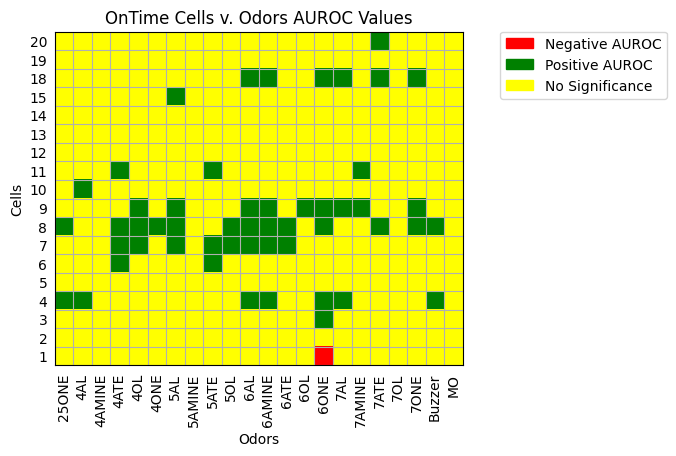

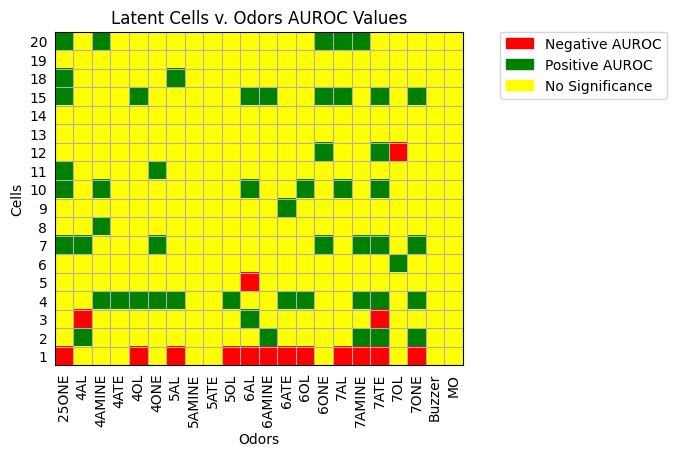

In [20]:

# STEP 7B: Plot Cell v Odor Significance Matricies 
# Note: One Optional Argument: 1) latentCellsOnly
# False by default, pass True to create matrix for latent cells
DewanPlotting.plot_significance_matricies(onTimePlottingData) # OnTime
DewanPlotting.plot_significance_matricies(latentPlottingData, True) # Latent

In [14]:
# STEP 7C: Plot Significant Cell Traces
# Plot significant cells v odors
# Note: two optional arguemnts 1) latentCellsOnly 2) plotAll
# Both are False by default; example lines for plotting all cells are included below
DewanPlotting.plot_cells(onTimePlottingData)
DewanPlotting.plot_cells(latentPlottingData, True)
# Uncomment to plot All Cells
# DewanPlotting.plot_cells(onTimePlottingData, latentCellsOnly = False, plotAll = True) 
# DewanPlotting.plot_cells(latentPlottingData, latentCellsOnly = True, plotAll = True) 

# Note 2: Parameter names are included for clarity, but only the boolean values are required when running the function

In [28]:
# STEP 7D: Plot Trial Variances
# Creates vertical scatter plots showing the change in flourescence for all trials for each cell-odor pairing
trialScatterData = DewanDataStore.AUROCdataStore(Combined_Baseline_Shift_Data, CellList, OdorData, FVData, fileHeader, FinalValveOnIndex, UnixTimeArray, baselineDuration, responseDuration, False)

# Note: One Optional Argument: 1) latentCellsOnly
# False by default, pass True to create plots for latent cells
DewanPlotting.plot_trial_variances(trialScatterData, onTimeAUROCSignificanceTable)
DewanPlotting.plot_trial_variances(trialScatterData, onTimeAUROCSignificanceTable, True)

## 8. Statistics

### Checkpoint 4: Load Data for Statistics

In [9]:
folder = 'ImagingAnalysis/AUROCImports'

Combined_Baseline_Shift_Data = DewanIOhandler.load_data_from_disk('Combined_Baseline_Shift_Data', fileHeader, folder)
FinalValveOnIndex = DewanIOhandler.load_data_from_disk('FVonIdx', fileHeader, folder)
UnixTimeArray = DewanIOhandler.load_data_from_disk('UnixTimeArray', fileHeader, folder)
OdorData = DewanIOhandler.load_data_from_disk('OdorData', fileHeader, folder)

folder = 'ImagingAnalysis/AUROCData'
onTimeAUROCSignificanceTable = DewanIOhandler.load_data_from_disk('onTimeAUROCSignificanceTable', fileHeader, folder)

folder = 'ImagingAnalysis/PreProcessedData'

CellList = DewanIOhandler.load_data_from_disk('CellList', fileHeader, folder)
FVData = DewanIOhandler.load_data_from_disk('FVData', fileHeader, folder)

VGAT5-11-16-22-Combined_Baseline_Shift_Data has loaded successfully!
VGAT5-11-16-22-FVonIdx has loaded successfully!
VGAT5-11-16-22-UnixTimeArray has loaded successfully!
VGAT5-11-16-22-OdorData has loaded successfully!
VGAT5-11-16-22-onTimeAUROCSignificanceTable has loaded successfully!
VGAT5-11-16-22-CellList has loaded successfully!
VGAT5-11-16-22-FVData has loaded successfully!


In [17]:
stats_data = DewanDataStore.AUROCdataStore(Combined_Baseline_Shift_Data, CellList, OdorData, FVData, fileHeader, FinalValveOnIndex, UnixTimeArray, baselineDuration, responseDuration, False)

significant_ontime_cells = np.unique(np.nonzero(onTimeAUROCSignificanceTable > 0)[0])

trial_averaged_responses_matrix = []

for cell in significant_ontime_cells:
    stats_data.update_cell(cell)
    
    trial_averaged_responses = []
    
    for odor in range(len(stats_data.unique_odors)):
        stats_data.update_odor(odor)
        baseline_data, evoked_data = DewanAUROC.collect_trial_data(stats_data, None, False)
        baseline_data, evoked_data = DewanStats.truncate_data(baseline_data, evoked_data)
        
        baseline_mean = np.mean(baseline_data)
        evoked_data = np.subtract(evoked_data, baseline_mean)
        average_response = np.mean(evoked_data)
        
        trial_averaged_responses.append(average_response)
    
    trial_averaged_responses_matrix.append(trial_averaged_responses)


In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_trial_averaged_responses = scaler.fit_transform(trial_averaged_responses_matrix)


In [50]:
from sklearn import metrics
from scipy import stats
correlation_coefficients = np.corrcoef(scaled_trial_averaged_responses, rowvar=False)
pairwise_distances = metrics.pairwise_distances(np.transpose(scaled_trial_averaged_responses), metric='correlation')
spearman_correlations = stats.spearmanr(scaled_trial_averaged_responses)

In [ ]:
# print(1-correlation_coefficients[0])
# print(pairwise_distances[0])
# print(spearman_correlations[0])

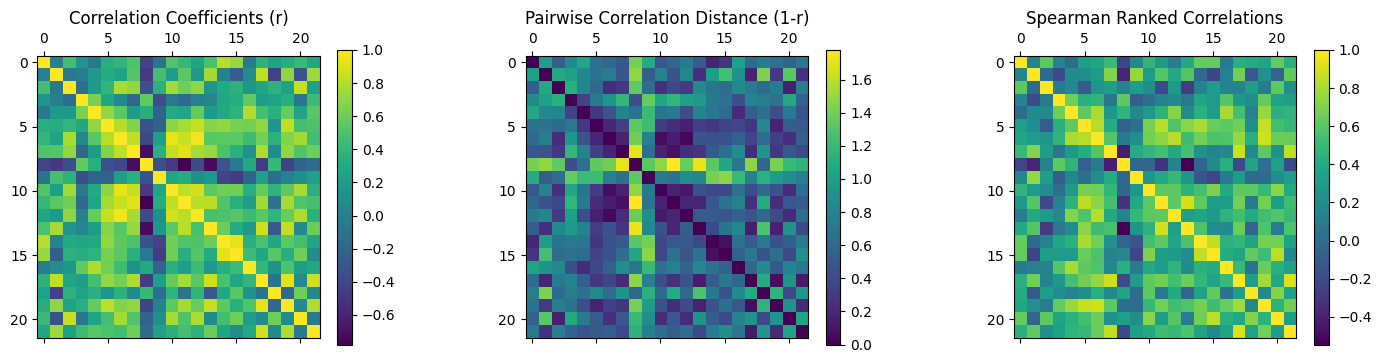

In [77]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1, 3)
fig.tight_layout()
fig.set_figwidth(15)
cc = ax[0].matshow(correlation_coefficients)
pd = ax[1].matshow(pairwise_distances)
sc = ax[2].matshow(spearman_correlations[0])
ax[0].set_title("Correlation Coefficients (r)")
ax[1].set_title("Pairwise Correlation Distance (1-r)")
ax[2].set_title("Spearman Ranked Correlations")
fig.colorbar(cc, ax=ax[0], shrink=0.7)
fig.colorbar(pd, ax=ax[1], shrink=0.7)
fig.colorbar(sc, ax=ax[2], shrink=0.7)

fig.savefig('correlations.jpg', dpi=800)